In [205]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt

In [204]:
rising_queries_all = pd.read_csv("C:/Users/varun/exported_files/rising_quer_all.csv")
rising_queries_all = pd.read_csv("C:/Users/varun/exported_files/top_quer_all.csv")

In [46]:
data = {
    'search_query': ["define feminism", "feminism definition", "python tutorial", "learn python"]
}
df = pd.DataFrame(data)

In [109]:
import pandas as pd
from fuzzywuzzy import fuzz

def group_similar_terms(df, threshold=80):
    # Create a dictionary to store the groups of similar terms for each column
    term_groups = {col: [] for col in df.columns}

    # Loop through each column and search query in the DataFrame
    for col in df.columns:
        for query in df[col]:
            found_group = None

            # Loop through existing groups to find a match
            for col2 in term_groups.keys():
                for group, terms in term_groups[col2]:
                    for term in terms:
                        similarity_score = fuzz.token_sort_ratio(query, term)
                        if similarity_score >= threshold:
                            found_group = group
                            break

                    if found_group:
                        break

            # If no existing group is found, create a new group
            if not found_group:
                found_group = f'{query}'
                print(found_group)
                term_groups[col].append((found_group, [found_group]))

            # Add the query to the found group
            else:
                term_groups[col].append((found_group, [found_group]))

    # Convert the dictionary back to a DataFrame for easier analysis
    grouped_data = {col: [term for group, terms in term_groups[col] for term in terms] for col in df.columns}
    grouped_df = pd.DataFrame(grouped_data)

    return grouped_df


grouped_df = group_similar_terms(rising_queries_all.iloc[:, 2:])
# grouped_df = group_similar_terms(df)

grouped_df


third wave feminism
vatican feminism
liberal feminism
ladies against feminism
black feminism
second wave feminism
definition of feminism
islamic feminism
full frontal feminism
feminist
what is feminism
feminism quotes
post feminism
feminism in australia
sarah palin breasts feminism
lesbian feminism
femail
feminism in india
feminism meaning
define feminism
thatcher feminism
shailene woodley feminism
definition
intersectional feminism
feminist theory
sex robot feminism
mumsnet feminism
fascism
bell hooks
bell hooks feminism
taylor swift
explain how african feminism can help you to implement equal opportunities for male and female
nan
history of feminism
anti feminism
feminism movement
forced feminism story
marxist feminism
feminine
lesbian vampire killers
letsbuy
love joy feminism
sex positive feminism
shailene woodley
emma watson
mad max feminism
everyday feminism
emma watson feminism
feminism in hindi
marxism
no nut november feminism
this is modern feminism talking
black lives matter
a

,TopQueries1,TopQueries2,TopQueries3,TopQueries4,TopQueries5,TopQueries6,TopQueries7,TopQueries8,TopQueries9,TopQueries10,...,TopQueries16,TopQueries17,TopQueries18,TopQueries19,TopQueries20,TopQueries21,TopQueries22,TopQueries23,TopQueries24,TopQueries25
0,third wave feminism,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,third wave feminism,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,vatican feminism,ladies against feminism,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,liberal feminism,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,third wave feminism,definition of feminism,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,what is feminism,definition of feminism,intersectional feminism,second wave feminism,second wave feminism,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
827,what is feminism,feminism meaning,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
828,what is feminism,feminist,feminism approach,feminism meaning,feminism approach,example of feminism,vatican feminism,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
829,second wave feminism,google scholar,intersectional feminism,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [206]:
grouped_df[300:]

,TopQueries1,TopQueries2,TopQueries3,TopQueries4,TopQueries5,TopQueries6,TopQueries7,TopQueries8,TopQueries9,TopQueries10,...,TopQueries16,TopQueries17,TopQueries18,TopQueries19,TopQueries20,TopQueries21,TopQueries22,TopQueries23,TopQueries24,TopQueries25
300,feminist,definition of feminism,what is feminism,vatican feminism,intersectional feminism,emma watson feminism,definition of feminism,define feminism,third wave feminism,everyday feminism,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
301,feminist,definition of feminism,what is feminism,definition of feminism,define feminism,black feminism,definition of feminism,what is feminism,everyday feminism,feminism quotes,...,vatican feminism,what is feminism,equality,feminism tumblr,third wave feminism,clinton feminism,beyonce feminism,anti feminism,feminist,sexism
302,definition of feminism,feminist,definition of feminism,what is feminism,everyday feminism,intersectional feminism,third wave feminism,second wave feminism,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
303,feminism meaning,feminism meaning,definition of feminism,feminism in india,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
304,definition of feminism,what is feminism,intersectional feminism,everyday feminism,define feminism,vatican feminism,third wave feminism,definition of feminism,second wave feminism,definition of feminism,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,what is feminism,definition of feminism,intersectional feminism,second wave feminism,second wave feminism,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
827,what is feminism,feminism meaning,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
828,what is feminism,feminist,feminism approach,feminism meaning,feminism approach,example of feminism,vatican feminism,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
829,second wave feminism,google scholar,intersectional feminism,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [114]:
rising_queries_all.iloc[300:, 2:]

,TopQueries1,TopQueries2,TopQueries3,TopQueries4,TopQueries5,TopQueries6,TopQueries7,TopQueries8,TopQueries9,TopQueries10,...,TopQueries16,TopQueries17,TopQueries18,TopQueries19,TopQueries20,TopQueries21,TopQueries22,TopQueries23,TopQueries24,TopQueries25
300,feminist,feminism definition,what is feminism,radical feminism,intersectional feminism,emma watson feminism,feminist definition,define feminism,third wave feminism,everyday feminism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,feminist,feminism definition,what is feminism,feminist definition,define feminism,black feminism,definition of feminism,white feminism,everyday feminism,feminism quotes,...,radical feminism,what is a feminism,equality,feminism tumblr,first wave feminism,hillary clinton feminism,beyonce feminism,anti feminism,feminists,sexism
302,feminism definition,feminist,definition of feminism,what is feminism,everyday feminism,intersectional feminism,third wave feminism,second wave feminism,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,feminism meaning,feminist meaning,feminism definition,feminism in india,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,feminism definition,what is feminism,intersectional feminism,everyday feminism,define feminism,radical feminism,third wave feminism,feminist definition,second wave feminism,definition of feminism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,what is feminism,feminism definition,intersectional feminism,waves of feminism,second wave feminism,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
827,what is feminism,feminism meaning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
828,what is feminism,feminist,feminism approach,feminism meaning,feminist approach,feminism examples,radical feminism,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
829,second wave feminism,google scholar,intersectional feminism,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
unique_values1 = pd.unique(grouped_df.values.flatten())

len(unique_values1), unique_values1

(260,
 array(['third wave feminism', 'nan', 'vatican feminism',
        'ladies against feminism', 'liberal feminism',
        'definition of feminism', 'black feminism', 'history of feminism',
        'what is feminism', 'second wave feminism', 'islamic feminism',
        'feminism quotes', 'full frontal feminism', 'social feminism',
        'kate chopin', 'do me feminism', 'feminist', 'anti feminism',
        'forced feminism story', 'eco feminism', 'feminism today',
        'feminism movement', 'marxist feminism', 'feminist theory',
        'define feminism', 'post feminism', 'feminism in literature',
        'betty friedan', 'feminine', 'feminism in india', 'femail',
        'feminism in australia', 'sarah palin breasts feminism', 'marxism',
        'phyllis schlafly', 'the flipside of feminism',
        'cultural feminism', '2nd wave feminism', 'lesbian feminism',
        'sexism', 'feminist ryan gosling', 'first wave of feminism',
        'feminism 101', 'feminism is for everybod

In [131]:
unique_values2 = pd.unique((rising_queries_all.iloc[:, 2:]).values.flatten())
len(unique_values2), unique_values2

(401,
 array(['third wave feminism', nan, 'vatican feminism',
        'ladies against feminism', 'liberal feminism',
        'definition of feminism', 'black feminism', 'history of feminism',
        'what is feminism', 'radical feminism', 'second wave feminism',
        'islamic feminism', 'feminism quotes', 'full frontal feminism',
        'socialist feminism', 'kate chopin', 'do me feminism', 'feminist',
        'feminism definition', 'anti feminism', 'first wave feminism',
        'forced feminism', 'eco feminism', 'forced feminism story',
        'feminism today', 'feminism movement', 'second wave of feminism',
        'marxist feminism', 'feminist theory', 'define feminism',
        'post feminism', 'feminism in literature', 'feminist movement',
        'feminist history', 'betty friedan', 'ontd feminism', 'feminine',
        'feminist quotes', 'feministing', 'feminism in london', 'fema',
        'feminism in australia', 'sarah palin breasts feminism', 'marxism',
        'social 

In [203]:
val_count1 = pd.value_counts(grouped_df.values.flatten())
val_count2 = pd.value_counts((rising_queries_all.iloc[:, 2:]).values.flatten())

filtered_val1 = val_count1[(val_count1 > 100) & (val_count1 < 2000)]
filtered_val2 = val_count2[(val_count2 > 100) & (val_count2 < 2000)]

filtered_val1, " " ,filtered_val2

(definition of feminism     1126
 what is feminism            804
 third wave feminism         563
 feminism meaning            551
 feminist                    488
 second wave feminism        472
 vatican feminism            405
 intersectional feminism     372
 define feminism             338
 liberal feminism            277
 feminism quotes             222
 everyday feminism           137
 black feminism              121
 marxist feminism            119
 mumsnet feminism            115
 feminism in india           103
 Name: count, dtype: int64,
 ' ',
 feminism definition        643
 what is feminism           550
 feminist                   454
 radical feminism           398
 intersectional feminism    353
 third wave feminism        334
 second wave feminism       321
 define feminism            301
 feminism meaning           281
 liberal feminism           275
 definition of feminism     237
 feminist definition        206
 first wave feminism        173
 feminist meaning     

AttributeError: module 'matplotlib.pyplot' has no attribute 'x'

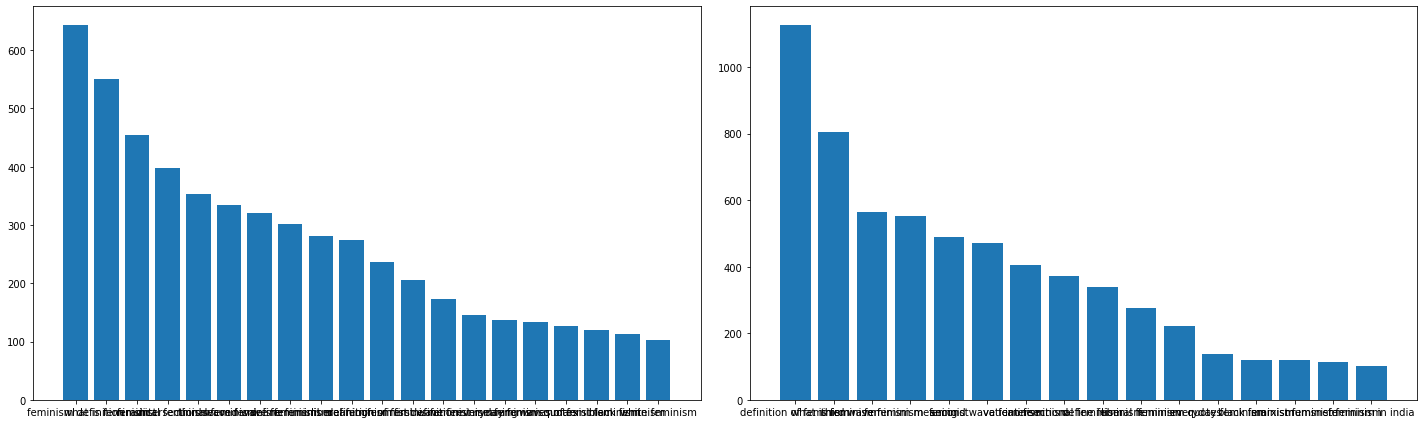

In [207]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))


axes[0].bar(filtered_val2.index, filtered_val2.values)
axes[1].bar(filtered_val1.index, filtered_val1.values)
plt.tight_layout()



In [ ]:
org_list = ["Google", "facebook", "twitter", "bing", ""]

In [228]:
grouped_df.to_csv("./cleaned_data/grouped_top_queries.csv", index = False)

In [229]:
grouped_top_queries = pd.read_csv("./cleaned_data/grouped_top_queries.csv")